In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(DEVICE, torch.cuda.get_device_name())

cuda NVIDIA GeForce RTX 2070 with Max-Q Design


# Data Preprocessing

## Visualize image and bounding boxes

(1333, 2000, 3)


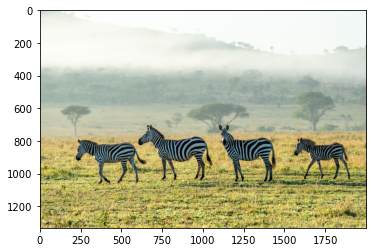

In [3]:
raw_img = cv2.imread("img.png")
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
print(raw_img.shape)
plt.imshow(raw_img)
plt.show()

In [4]:
bboxes_raw = np.array([[223, 782, 623, 1074], [597, 695, 1038, 1050], [1088, 699, 1452, 1057], [1544, 771, 1914, 1063]])
labels = np.array([1, 1, 1, 1])

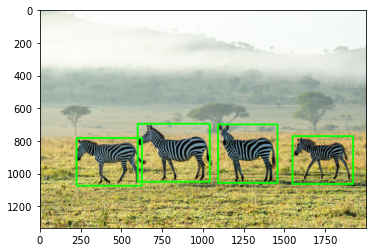

In [5]:
raw_img_clone = np.copy(raw_img)
for bbox in bboxes_raw:
    cv2.rectangle(img=raw_img_clone, pt1=bbox[0:2], pt2=bbox[2:4], color=(0, 255, 0), thickness=10)

plt.imshow(raw_img_clone)
plt.show()

## Resize image and bounding boxes

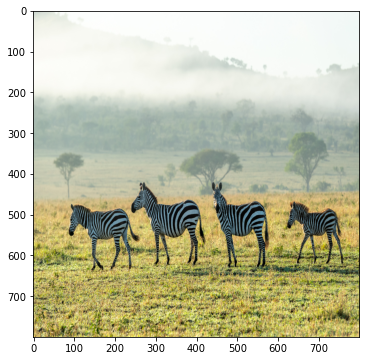

In [6]:
img = cv2.resize(raw_img, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.show()

0.4 0.6001500375093773
[[ 89 469 249 644]
 [238 417 415 630]
 [435 419 580 634]
 [617 462 765 637]]


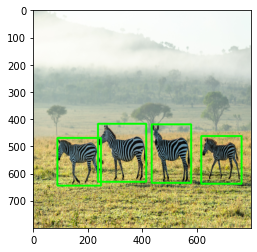

In [7]:
w_ratio = 800 / np.shape(raw_img)[1]
h_ratio = 800 / np.shape(raw_img)[0]

print(w_ratio, h_ratio)

ratio_list = [w_ratio, h_ratio, w_ratio, h_ratio]
bboxes = []

for bbox in bboxes_raw:
    bbox = [int(a * b) for a, b in zip(bbox, ratio_list)]
    bboxes.append(bbox)

bboxes = np.array(bboxes)
print(bboxes)

img_clone = np.copy(img)
for bbox in bboxes:
    cv2.rectangle(img_clone, pt1=bbox[0:2], pt2=bbox[2:4], color=(0, 255, 0), thickness=5)

plt.imshow(img_clone)
plt.show()

# Define Features extractor

## Load pretraineed VGG16

In [8]:
model = torchvision.models.vgg16(pretrained=True).to(DEVICE)
features = list(model.features)
print(features)
print(len(features))

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

## Only collect required layers

In [9]:
dummy_img = torch.zeros((1, 3, 800, 800)).float()
print(dummy_img.shape)

req_features = []
output = dummy_img.clone().to(DEVICE)

out_channels = None
for feature in features:
    output = feature(output)
    if output.size()[2] < 800 // 16:
        break
    req_features.append(feature)
    out_channels = output.size()[1]

print(len(req_features))
print(out_channels)

torch.Size([1, 3, 800, 800])
30
512


In [10]:
print(req_features)
print("--------------------")
print(*req_features)

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [11]:
faster_rcnn_feature_extractor = nn.Sequential(*req_features)

In [12]:
transform = transforms.Compose([transforms.ToTensor()])
img_tensor = transform(img).to(DEVICE)
img_tensor = img_tensor.unsqueeze(0)
output_map = faster_rcnn_feature_extractor(img_tensor)

print(output_map.shape)

torch.Size([1, 512, 50, 50])


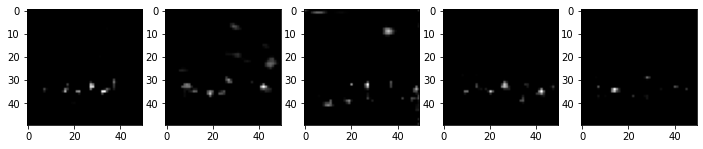

In [13]:
img_array = output_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12, 4))
fig_no = 1

for i in range(5):
    fig.add_subplot(1, 5, fig_no)
    plt.imshow(img_array[i], cmap="gray")
    fig_no += 1

plt.show()

# Generate Anchor Boxes

## Generate Anchors

In [14]:
feature_size = 800 // 16
ctr_x = np.arange(16, (feature_size + 1) * 16, 16)
ctr_y = np.arange(16, (feature_size + 1) * 16, 16)
print(len(ctr_x))
print(ctr_x)

50
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [15]:
index = 0
ctr = np.zeros((2500, 2))

for x in ctr_x:
    for y in ctr_y:
        ctr[index, 0] = x - 8
        ctr[index, 1] = y - 8
        index += 1

print(ctr.shape)
print(ctr[:10, :])

(2500, 2)
[[  8.   8.]
 [  8.  24.]
 [  8.  40.]
 [  8.  56.]
 [  8.  72.]
 [  8.  88.]
 [  8. 104.]
 [  8. 120.]
 [  8. 136.]
 [  8. 152.]]


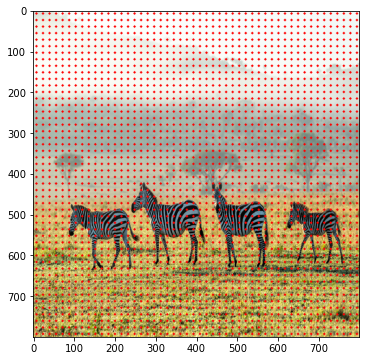

In [16]:
img_clone_2 = np.copy(img)
ctr_int = ctr.astype("int32")

plt.figure(figsize=(6, 6))
for c in ctr_int:
    cv2.circle(img_clone_2, center=c, radius=1, color=(255, 0, 0), thickness=3)

plt.imshow(img_clone_2)
plt.show()

## Generate Anchor boxes

In [17]:
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16

anchor_boxes = np.zeros(((feature_size * feature_size * 9), 4))
index = 0

for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1. / ratios[i])

            anchor_boxes[index, 0] = ctr_x - w / 2.
            anchor_boxes[index, 1] = ctr_y - h / 2.
            anchor_boxes[index, 2] = ctr_x + w / 2.
            anchor_boxes[index, 3] = ctr_y + h / 2.
            index += 1

print(anchor_boxes.shape)
print(anchor_boxes[:10, :])

(22500, 4)
[[ -82.50966799  -37.254834     98.50966799   53.254834  ]
 [-173.01933598  -82.50966799  189.01933598   98.50966799]
 [-354.03867197 -173.01933598  370.03867197  189.01933598]
 [ -56.          -56.           72.           72.        ]
 [-120.         -120.          136.          136.        ]
 [-248.         -248.          264.          264.        ]
 [ -37.254834    -82.50966799   53.254834     98.50966799]
 [ -82.50966799 -173.01933598   98.50966799  189.01933598]
 [-173.01933598 -354.03867197  189.01933598  370.03867197]
 [ -66.50966799  -37.254834    114.50966799   53.254834  ]]


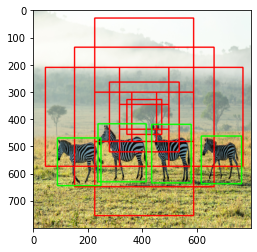

In [18]:
img_clone = np.copy(img)

for i in range(11025, 11034):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])

    cv2.rectangle(img_clone, pt1=(x1, y1), pt2=(x2, y2), color=(255, 0, 0), thickness=3)

for bbox in bboxes:
    cv2.rectangle(img_clone, pt1=bbox[0:2], pt2=bbox[2:4], color=(0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

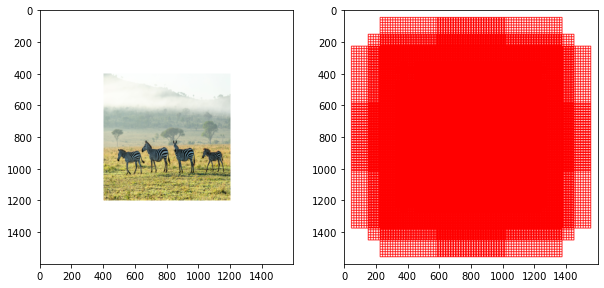

In [19]:
img_clone_3 = np.copy(img)
img_clone_4 = cv2.copyMakeBorder(img_clone_3, 400, 400, 400, 400, cv2.BORDER_CONSTANT, value=(255, 255, 255))
img_clone_5 = np.copy(img_clone_4)

for anchor_box in anchor_boxes:
    x1 = int(anchor_box[0])
    y1 = int(anchor_box[1])
    x2 = int(anchor_box[2])
    y2 = int(anchor_box[3])

    cv2.rectangle(img_clone_5, pt1=(x1 + 400, y1 + 400), pt2=(x2 + 400, y2 + 400), color=(255, 0, 0), thickness=3)

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(img_clone_4)
plt.subplot(122)
plt.imshow(img_clone_5)
plt.show()

# Target Anchors

## Only choose anchor boxes inside the image

In [20]:
index_inside = np.where(
    (anchor_boxes[:, 0] >= 0) & (anchor_boxes[:, 1] >= 0) & (anchor_boxes[:, 2] <= 800) & (anchor_boxes[:, 3] <= 800))[
    0]
print(index_inside.shape)

valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


## Calculate IoUs

In [21]:
ious = np.empty((len(valid_anchor_boxes), 4), dtype=np.float32)
ious.fill(0)

for i, anchor_box in enumerate(valid_anchor_boxes):
    xa1, ya1, xa2, ya2 = anchor_box
    anchor_area = (xa2 - xa1) * (ya2 - ya1)

    for j, gt_box in enumerate(bboxes):
        xb1, yb1, xb2, yb2 = gt_box
        box_area = (xb2 - xb1) * (yb2 - yb1)

        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])

        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
            iou = inter_area / (anchor_area + box_area - inter_area)
        else:
            iou = 0

        ious[i, j] = iou

print(ious.shape)
print(ious[8930:8940, :])

(8940, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


## Sample positive / negative anchor boxes

In [22]:
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[6518 5356 5925 6732]
[0.58514285 0.5752716  0.5255493  0.6325869 ]
[5356 5602 5848 5925 6077 6084 6091 6094 6098 6105 6171 6323 6330 6337
 6340 6344 6351 6413 6417 6420 6427 6518 6524 6569 6576 6583 6586 6590
 6597 6659 6663 6666 6673 6732 6764 6770 6827 6894 6960 6992 6998 7055
 7122 7188 7283]


In [23]:
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)

max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(8940,)
[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]


In [24]:
label = np.empty((len(index_inside),), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [25]:
POS_IOU_THRESHOLD = 0.7
NEG_IOU_THRESHOLD = 0.3

label[gt_argmax_ious] = 1
label[max_ious >= POS_IOU_THRESHOLD] = 1
label[max_ious < NEG_IOU_THRESHOLD] = 0

In [26]:
N_SAMPLE = 256
POS_RATIO = 0.5
N_POS = POS_RATIO * N_SAMPLE

pos_index = np.where(label == 1)[0]

if len(pos_index) > N_POS:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - N_POS), replace=False)
    label[disable_index] = -1

N_NEG = N_SAMPLE * np.sum(label == 1)
neg_index = np.where(label == 0)[0]

if len(neg_index) > N_NEG:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - N_NEG), replace=False)
    label[disable_index] = -1

In [27]:
max_iou_bboxes = bboxes[argmax_ious]
print(max_iou_bboxes.shape)

height = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
width = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
ctr_y = valid_anchor_boxes[:, 1] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 0] + 0.5 * width

base_height = max_iou_bboxes[:, 3] - max_iou_bboxes[:, 1]
base_width = max_iou_bboxes[:, 2] - max_iou_bboxes[:, 0]
base_ctr_y = max_iou_bboxes[:, 1] + 0.5 * base_height
base_ctr_x = max_iou_bboxes[:, 0] + 0.5 * base_width

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

anchor_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(anchor_locs.shape)

(8940, 4)
(8940, 4)


In [28]:
anchor_labels = np.empty((len(anchor_boxes)), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)
print(anchor_labels[:10])

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)
print(anchor_locations[:10, :])

(22500,)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(22500, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


# RPN (Region Proposal Network)

## Define RPN

In [29]:
IN_CHANNELS = 512
MID_CHANNELS = 512
N_ANCHOR = 9

conv1 = nn.Conv2d(IN_CHANNELS, MID_CHANNELS, kernel_size=3, stride=1, padding=1).to(DEVICE)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

reg_layer = nn.Conv2d(MID_CHANNELS, N_ANCHOR * 4, kernel_size=1, stride=1, padding=0).to(DEVICE)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

cls_layer = nn.Conv2d(MID_CHANNELS, N_ANCHOR * 2, kernel_size=1, stride=1, padding=0).to(DEVICE)
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

## Classification and Bounding box regression

In [30]:
x = conv1(output_map.to(DEVICE))
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)

print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [31]:
print(f"Shape of pred_anchor_locs: {pred_anchor_locs.shape}")
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(f"Shape of pred_anchor_locs: {pred_anchor_locs.shape}")

print(f"Shape of pred_cls_scores: {pred_cls_scores.shape}")
pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(f"Shape of pred_cls_scores: {pred_cls_scores.shape}")

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(f"Shape of objectness_score: {objectness_score.shape}")

pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print(f"Shape of pred_cls_scores: {pred_cls_scores.shape}")

Shape of pred_anchor_locs: torch.Size([1, 36, 50, 50])
Shape of pred_anchor_locs: torch.Size([1, 22500, 4])
Shape of pred_cls_scores: torch.Size([1, 18, 50, 50])
Shape of pred_cls_scores: torch.Size([1, 50, 50, 18])
Shape of objectness_score: torch.Size([1, 22500])
Shape of pred_cls_scores: torch.Size([1, 22500, 2])


In [32]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, gt_rpn_loc.shape)
print(rpn_score.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 4])
torch.Size([22500, 2]) torch.Size([22500])


## Multi-task loss

In [33]:
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(DEVICE), ignore_index=-1)
print(rpn_cls_loss)

tensor(0.6897, device='cuda:0', grad_fn=<NllLossBackward0>)


In [34]:
pos = gt_rpn_score > 0
print(pos.shape)
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(rpn_loc_loss.sum())

torch.Size([22500])
torch.Size([22500, 4])
torch.Size([45, 4]) torch.Size([45, 4])
tensor(7.4077, dtype=torch.float64, grad_fn=<SumBackward0>)


In [35]:
RPN_LAMBDA = 10

n_reg = (gt_rpn_score > 0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / n_reg
rpn_loss = rpn_cls_loss + (RPN_LAMBDA * rpn_loc_loss)
print(rpn_loss)

tensor(2.3358, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


# Proposal layer

## Transform anchor boxes

In [36]:
NMS_THRESH = 0.7
N_TRAIN_PRE_NMS = 12000
N_TRAIN_POST_NMS = 2000
N_TEST_PRE_NMS = 6000
N_TEST_POST_NMS = 300
MIN_SIZE = 16

In [37]:
anc_height = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_width = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_ctr_y = anchor_boxes[:, 1] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 0] + 0.5 * anc_width
print(anc_ctr_x.shape)

(22500,)


In [38]:
pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()

dy = pred_anchor_locs_numpy[:, 1::4]
dx = pred_anchor_locs_numpy[:, 0::4]
dh = pred_anchor_locs_numpy[:, 3::4]
dw = pred_anchor_locs_numpy[:, 2::4]
print(dy.shape)

(22500, 1)


In [39]:
ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500, 1)


In [40]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_x - 0.5 * w
roi[:, 1::4] = ctr_y - 0.5 * h
roi[:, 2::4] = ctr_x + 0.5 * w
roi[:, 3::4] = ctr_y + 0.5 * h

print(roi.shape)

(22500, 4)


## Clip the anchor boxes to the image

In [41]:
IMG_SIZE = (800, 800)
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, IMG_SIZE[0])
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, IMG_SIZE[1])

print(roi.shape, np.max(roi), np.min(roi))

(22500, 4) 800.0 0.0


In [42]:
hs = roi[:, 3] - roi[:, 1]
ws = roi[:, 2] - roi[:, 0]

keep = np.where((hs >= MIN_SIZE) & (ws >= MIN_SIZE))[0]
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)

(22500,) (22500, 4) (22500,)


## Select top-12000 anchor boxes by obojectness score

In [43]:
order = score.ravel().argsort()[::-1]
print(order.shape)

(22500,)


In [44]:
order = order[:N_TRAIN_PRE_NMS]
roi = roi[order, :]
print(order.shape, roi.shape)

(12000,) (12000, 4)


## Non maximum suppression (select 2000 bounding boxes)

In [45]:
x1 = roi[:, 0]
y1 = roi[:, 1]
x2 = roi[:, 2]
y2 = roi[:, 3]

areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [46]:
order = order.argsort()[::-1]
keep = []

while order.size > 0:
    i = order[0]
    keep.append(i)

    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])

    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)

    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)
    inds = np.where(ovr <= NMS_THRESH)[0]
    order = order[inds + 1]

keep = keep[:N_TRAIN_POST_NMS]
roi = roi[keep]
print(len(keep), roi.shape)

2000 (2000, 4)


# Proposal Target layer

## Calculate IoUs

In [47]:
N_SAMPLE = 128
POS_RATIO = 0.25
POS_IOU_THRESH = 0.5
NEG_IOU_THRESH_HI = 0.5
NEG_IOU_THRESH_LO = 0.0

In [48]:
ious = np.empty((len(roi), bboxes.shape[0]), dtype=np.float32)
ious.fill(0)

for num1, i in enumerate(roi):
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 - xa1)

    for num2, j in enumerate(bboxes):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2 - yb1) * (xb2 - xb1)

        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])

        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = inter_area / (anchor_area + box_area - inter_area)
        else:
            iou = 0
        ious[num1, num2] = iou
print(ious.shape)

(2000, 4)


In [49]:
gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)

print(gt_assignment)
print(max_iou)

gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[3 0 3 ... 0 0 0]
[0.04925871 0.         0.25459442 ... 0.         0.         0.        ]
[1 1 1 ... 1 1 1]


## Select foreground(positive) samples

In [50]:
pos_roi_per_image = 32
pos_index = np.where(max_iou >= POS_IOU_THRESH)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))

if pos_index.size > 0:
    pos_index = np.random.choice(pos_index, size=pos_roi_per_this_image, replace=False)

print(pos_roi_per_this_image)
print(pos_index)

32
[ 544  599  542  716 1109  674  689  767  745  612  631  600  650  560
  920  671  601  615  676  730  617  715  559  930  657  687  748  760
  791  558  633  712]


## Select background(negative) samplees

In [51]:
neg_index = np.where((max_iou < NEG_IOU_THRESH_HI) & (max_iou >= NEG_IOU_THRESH_LO))[0]
neg_roi_per_this_image = N_SAMPLE - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))

if neg_index.size > 0:
    neg_index = np.random.choice(neg_index, size=neg_roi_per_this_image, replace=False)

print(neg_roi_per_this_image)
print(neg_index)

96
[ 893  521 1177 1358  454  691 1267 1484  373 1980  345  714 1914 1011
  301 1426  902  799 1501  637 1788 1572 1761  276 1741  285 1131   60
  404 1003 1867 1607  726  916  358  991  287 1904  728 1480 1071   77
  830  816 1757 1512 1384 1045  614  845  156 1272  236  363 1862 1985
  151 1881  292  417 1811 1261 1126 1870 1283 1099  567  196  216  952
 1051 1370 1724  992  659  956  372 1316 1746  529  185  980 1833 1070
  323  651  445 1300  928 1158  959 1706  142  621 1987 1224]


## Visualization

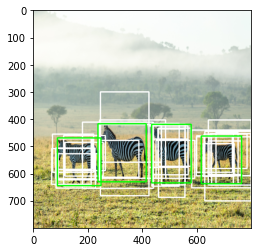

In [52]:
img_clone = np.copy(img)

for i in range(pos_roi_per_this_image):
    x1, y1, x2, y2 = roi[pos_index[i]].astype(int)
    cv2.rectangle(img_clone, pt1=(x1, y1), pt2=(x2, y2), color=(255, 255, 255), thickness=3)

for i in range(len(bboxes)):
    cv2.rectangle(img_clone, pt1=(bboxes[i][0], bboxes[i][1]), pt2=(bboxes[i][2], bboxes[i][3]), color=(0, 255, 0),
                  thickness=3)

plt.imshow(img_clone)
plt.show()

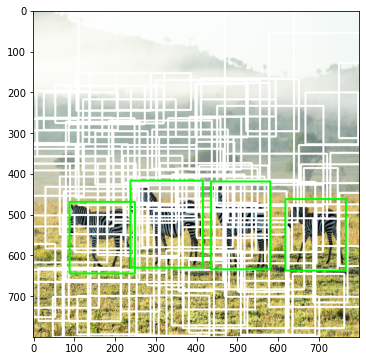

In [53]:
img_clone = np.copy(img)

plt.figure(figsize=(9, 6))

for i in range(neg_roi_per_this_image):
    x1, y1, x2, y2 = roi[neg_index[i]].astype(int)
    cv2.rectangle(img_clone, pt1=(x1, y1), pt2=(x2, y2), color=(255, 255, 255), thickness=3)

for i in range(len(bboxes)):
    cv2.rectangle(img_clone, pt1=(bboxes[i][0], bboxes[i][1]), pt2=(bboxes[i][2], bboxes[i][3]), color=(0, 255, 0),
                  thickness=3)

plt.imshow(img_clone)
plt.show()

## Gather positive/negative samples

In [54]:
keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

(128, 4)


In [55]:
bbox_for_sampled_roi = bboxes[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

(128, 4)


In [56]:
width = sample_roi[:, 2] - sample_roi[:, 0]
height = sample_roi[:, 3] - sample_roi[:, 1]
ctr_x = sample_roi[:, 0] + 0.5 * width
ctr_y = sample_roi[:, 1] + 0.5 * height

base_width = bbox_for_sampled_roi[:, 2] = bbox_for_sampled_roi[:, 0]
base_height = bbox_for_sampled_roi[:, 3] = bbox_for_sampled_roi[:, 1]
base_ctr_x = bbox_for_sampled_roi[:, 0] + 0.5 * base_width
base_ctr_y = bbox_for_sampled_roi[:, 1] + 0.5 * base_height

In [57]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dx = (base_ctr_x - ctr_x) / width
dy = (base_ctr_y - ctr_y) / height
dw = np.log(base_width / width)
dh = np.log(base_height / height)

gt_roi_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(gt_roi_locs.shape)

(128, 4)


# RoI pooling

## Concatenate labels with bbox coordinates

In [58]:
rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

torch.Size([128, 4]) torch.Size([128])


In [59]:
indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 5])


## RoI pooling

In [60]:
SIZE = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(SIZE[0], SIZE[1])

In [61]:
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1 / 16.0)
rois = rois.long()
num_rois = rois.size(0)

for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    im = output_map.narrow(0, im_idx, 1)[..., roi[1]:(roi[3] + 1), roi[2]:(roi[4] + 1)]
    tmp = adaptive_max_pool(im)
    output.append(tmp[0])

output = torch.cat(output, 0)
print(output.size())

torch.Size([128, 512, 7, 7])


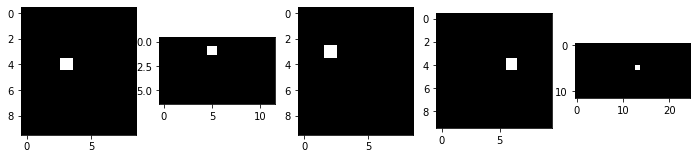

In [62]:
fig = plt.figure(figsize=(12, 4))
fig_no = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = output_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4] + 1), roi[1]:(roi[3] + 1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, fig_no)
    plt.imshow(tmp, cmap="gray")

    fig_no += 1

plt.show()

In [63]:
k = output.view(output.size(0), -1)
print(k.shape)

torch.Size([128, 25088])


# Fast R-CNN

## Classifier and Bounding box regressor

In [64]:
roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]).to(DEVICE)
cls_loc = nn.Linear(4096, 2 * 4).to(DEVICE)
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

score = nn.Linear(4096, 2).to(DEVICE)

In [65]:
k = roi_head_classifier(k.to(DEVICE))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)

print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 8]) torch.Size([128, 2])


In [66]:
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


In [67]:
print(gt_roi_labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]



## Classification loss

In [68]:
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)

torch.Size([128, 4]) torch.Size([128])


## Regression loss

In [69]:
N_SAMPLE = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(N_SAMPLE, -1, 4)
print(roi_loc.shape)

torch.Size([128, 2, 4])


In [70]:
roi_loc = roi_loc[torch.arange(0, N_SAMPLE).long(), gt_roi_label]
print(roi_loc.shape)

torch.Size([128, 4])


In [71]:
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

torch.Size([128, 4])


In [72]:
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(roi_loc_loss.sum())

torch.Size([32, 4]) torch.Size([32, 4])
tensor(64.1958, dtype=torch.float64, grad_fn=<SumBackward0>)


## Multi-task loss

In [73]:
ROI_LAMBDA = 10.
roi_loss = roi_cls_loss + (ROI_LAMBDA * roi_loc_loss)
print(roi_loss)

total_loss = rpn_loss + roi_loss.to(DEVICE)
print(total_loss)

tensor([[ 0.8325,  6.7942,  2.8472,  4.4804],
        [ 0.7554,  6.3166,  1.5304,  1.6560],
        [ 0.7557,  5.8670,  1.7384,  4.7588],
        [ 0.7794,  9.2530,  1.7460,  2.1574],
        [ 1.2995,  2.1593,  1.3325,  2.8127],
        [ 9.8261,  3.7059,  7.1555,  1.2178],
        [ 9.9103,  6.4880,  6.8173,  1.6934],
        [ 0.8730,  2.5147,  1.2442,  1.6503],
        [ 8.0634,  7.5781,  6.6796,  2.9061],
        [10.5543, 11.5218,  7.6166,  5.9298],
        [11.1314,  1.5076,  9.2058,  1.0818],
        [ 0.7378, 10.7758,  1.6596,  5.6080],
        [ 2.2200,  3.9771,  1.0835,  1.7634],
        [25.7207,  6.1657, 15.1416,  0.7787],
        [ 8.4020,  5.8637,  7.7090,  1.0639],
        [10.1512,  5.2601,  9.3505,  1.7841],
        [ 0.9915, 10.0791,  1.4597,  9.5719],
        [13.2416, 12.5551,  7.9042,  5.2253],
        [13.4683,  8.7025, 12.9189,  2.1564],
        [ 9.2600, 16.0135,  6.6260,  8.9044],
        [17.4863,  9.0678, 10.9110,  3.8106],
        [ 1.1528, 12.3549,  1.7439